In [7]:
#!/usr/bin/env python
# coding: utf-8

# === Cell 1: imports & config ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const
from pathlib import Path
import math
import os

try:
    import py21cmfast as p21
except Exception as e:
    raise RuntimeError("py21cmfast is required for these plots.") from e

# --- physical constants (cgs), consistent with secondrun.py ---
sigma_T = const.sigma_T.cgs.value       # [cm^2]
MPC_CM  = 3.0856775814913673e24         # [cm]
c_cms   = const.c.cgs.value             # speed of light [cm/s]
T_CMB_K = 2.7255                        # CMB temperature [K]

# --- redshift grid ---
ZS = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0]  # tweak freely (strictly decreasing helps some routines)

# --- user-tunable parameters ---
FIXED_HII_EFF_FACTOR = 10.0  # Fixed HII_EFF_FACTOR
BOX_SIZES = [250.0, 450.0, 650.0]  # Box sizes in Mpc
BASE_HII_DIM = 64
BASE_BOX_LEN = 200.0
cache_dir = Path("pq_cache")
cache_dir.mkdir(exist_ok=True)

In [8]:
# === Cell 2: helpers ===
def ne0_cgs(Y_He=0.24, include_He=True):
    """Mean electron density today [cm^-3], including singly-ionized He if include_He."""
    m_p    = const.m_p.cgs.value
    rho_c0 = cosmo.critical_density0.cgs.value
    Om_b   = cosmo.Ob0
    n_b0   = (Om_b * rho_c0) / m_p
    X_H    = 1.0 - Y_He
    n_H0   = X_H * n_b0
    if include_He:
        y = Y_He / (4.0 * X_H)  # He/H by number
        electrons_per_H = 1.0 + y  # H (1) + singly ionized He (1)
    else:
        electrons_per_H = 1.0
    return n_H0 * electrons_per_H

ne0 = ne0_cgs()
print("n_e0 [cm^-3] =", ne0)

def run_coeval_fields(z, HII_DIM, BOX_LEN, astro_overrides=None):
    """
    Run a 21cmFAST coeval box and return needed fields.
    astro_overrides: optional dict forwarded into astro_params for p21.run_coeval.
    """
    user_params = {"HII_DIM": int(HII_DIM), "BOX_LEN": float(BOX_LEN)}

    astro_params = {}
    if astro_overrides:
        astro_params.update(astro_overrides)

    coeval = p21.run_coeval(
        redshift=float(z),
        user_params=user_params,
        astro_params=astro_params,
        write=False,
    )
    delta  = coeval.density               # matter overdensity δ (dimensionless)
    xH     = coeval.xH_box                # neutral fraction
    chi    = 1.0 - xH                     # ionized fraction χ
    vx     = coeval.lowres_vx * 1e5       # km/s -> cm/s
    vy     = coeval.lowres_vy * 1e5
    vz     = coeval.lowres_vz * 1e5
    return delta, chi, vx, vy, vz


n_e0 [cm^-3] = 2.0643566911920377e-07


In [9]:



#== Cell 5a: q_perp FFT and power spectrum function ===

"""
Build q=(1+δ)χv, FFT to Q(k), project to Q_perp, estimate P_{q_perp}(k).

Args:
    delta, chi, vx, vy, vz : 3D numpy arrays (shape [N,N,N]) in real space
    BOX_LEN : float, box size in Mpc (comoving)
    nbins : int or None, number of k-bins (if None a heuristic is used)
    HII_EFF_FACTOR : optional numeric label. Not used in computation,
            but returned for bookkeeping.

Returns:
    (k_bin (Mpc^-1), P_bin (cm^2 s^-2 Mpc^3),
    qperp_slice (real-space |q_perp| mid-slice),
    kplane_amp (|Q| mid-kz plane, fftshifted),
    kplane_amp_perp (|Q_perp| mid-kz plane, fftshifted),
    kx2d, ky2d (fftshifted, for plotting axes),
    HII_EFF_FACTOR)  # final element is exactly the input HII_EFF_FACTOR (for labels/filenames)
"""
"""
Robust q_perp FFT + binned power estimator.
Returns (kvals, pvals, qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, HII_EFF_FACTOR)
"""
    
    # --- real-space q ---
def qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None, HII_EFF_FACTOR=None, los_direction=[0, 0 , 1]):
    # Add z as a parameter!
    
    # --- real-space q ---
    ne_fluct = (1.0 + delta) * chi  # ADD THIS
    qx = ne_fluct * vx
    qy = ne_fluct * vy
    qz = ne_fluct * vz

    # --- geometry ---
    N = qx.shape[0]
    L = float(BOX_LEN)          # Mpc (comoving)
    d = L / N                   # Mpc
    V = L**3                    # Mpc^3

    # --- k-grid (1/Mpc) ---
    kfreq = np.fft.fftfreq(N, d=d) * 2.0*np.pi  # radians per Mpc
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing="ij")
    k2 = kx*kx + ky*ky + kz*kz
    k = np.sqrt(k2)
    k2_safe = np.where(k2 == 0.0, np.inf, k2)   # avoid div0 at k=0

    # --- FFT with continuous-FT normalization (× voxel volume) ---
    Qx = np.fft.fftn(qx) * (d**3)
    Qy = np.fft.fftn(qy) * (d**3)
    Qz = np.fft.fftn(qz) * (d**3)

    #---------Normalise LOS direction ---------------------

    los_dir = np.array(los_direction)/np.linalg.norm(los_direction)
    k_dot_los = kx*los_dir[0] + ky*los_dir[1] + kz*los_dir[2]
    perp_mask = np.abs(k_dot_los)<1e-6 #Appproximately perpendicular thresholding


    # --- project to transverse: Q_perp = Q - khat (Q·khat) but now only for k perpendicular to the LOS [0,0,1]---
    kdotQ_over_k2 = np.zeros_like(kx, dtype=complex)
    kdotQ_over_k2[perp_mask] = (Qx[perp_mask]*kx[perp_mask] + Qy[perp_mask]*ky[perp_mask] + Qz[perp_mask]*kz[perp_mask])/k2_safe[perp_mask]
    Qx_perp = Qx.copy().astype(complex)
    Qy_perp = Qy.copy().astype(complex)
    Qz_perp = Qz.copy().astype(complex)
    Qx_perp[perp_mask] -= kdotQ_over_k2[perp_mask] * kx[perp_mask]
    Qy_perp[perp_mask] -= kdotQ_over_k2[perp_mask] * ky[perp_mask]
    Qz_perp[perp_mask] -= kdotQ_over_k2[perp_mask] * kz[perp_mask]

    # --- power estimator: P(k) = <|Q_perp|^2>/V ---
    Qperp2 = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)
    p_flat = (Qperp2 / V).ravel()
    k_flat = k.ravel()

    # --- radial binning in k ---
    if nbins is None:
        nbins = int(np.ceil(np.cbrt(N) * 8))
    nbins = max(2, int(nbins))

    # find positive, non-zero unique kfreqs
    unique_kfreqs = np.unique(np.abs(kfreq))
    pos_kfreqs = unique_kfreqs[unique_kfreqs > 0.0]
    if pos_kfreqs.size == 0:
        kmin = 1e-6
    else:
        kmin = pos_kfreqs.min()

    kmax = np.abs(kfreq).max() * np.sqrt(3.0)
    if kmax <= kmin:
        kmax = kmin * 10.0

    bins = np.geomspace(kmin, kmax, nbins)
    digit = np.digitize(k_flat, bins)

    kvals, pvals, counts = [], [], []
    for i in range(1, len(bins)):
        mask = digit == i
        if not np.any(mask):
            continue
        kvals.append(k_flat[mask].mean())
        pvals.append(p_flat[mask].mean())
        counts.append(int(mask.sum()))

    # --- optional visuals: real-space |q_perp| mid-slice, and k-plane amplitudes (fftshifted) ---
    qx_perp_r = np.fft.ifftn(Qx_perp) / (d**3)
    qy_perp_r = np.fft.ifftn(Qy_perp) / (d**3)
    qz_perp_r = np.fft.ifftn(Qz_perp) / (d**3)
    qperp_mag = np.sqrt(np.abs(qx_perp_r)**2 + np.abs(qy_perp_r)**2 + np.abs(qz_perp_r)**2).real

    mid = N//2
    qperp_slice = qperp_mag[mid, :, :]

    plane_Q      = (np.abs(Qx)**2 + np.abs(Qy)**2 + np.abs(Qz)**2)**0.5
    plane_Qperp  = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)**0.5
    kplane_amp       = np.fft.fftshift(plane_Q[:, :, mid])
    kplane_amp_perp  = np.fft.fftshift(plane_Qperp[:, :, mid])

    kx2 = np.fft.fftshift(kx[:, :, mid])
    ky2 = np.fft.fftshift(ky[:, :, mid])

    return (np.array(kvals), np.array(pvals),
            qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, HII_EFF_FACTOR)


# In[28]:





Processing Box: 250 Mpc, 80^3 (Δx=3.12 Mpc) (HII_EFF_FACTOR=10.0) ...


/home/swanith/.local/lib/python3.10/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


  D_3000 (μK^2) ≈ 0.01372  (cached as 250Mpc)

Processing Box: 450 Mpc, 144^3 (Δx=3.12 Mpc) (HII_EFF_FACTOR=10.0) ...
  D_3000 (μK^2) ≈ 0.01645  (cached as 450Mpc)

Processing Box: 650 Mpc, 208^3 (Δx=3.12 Mpc) (HII_EFF_FACTOR=10.0) ...
  D_3000 (μK^2) ≈ 0.01777  (cached as 650Mpc)


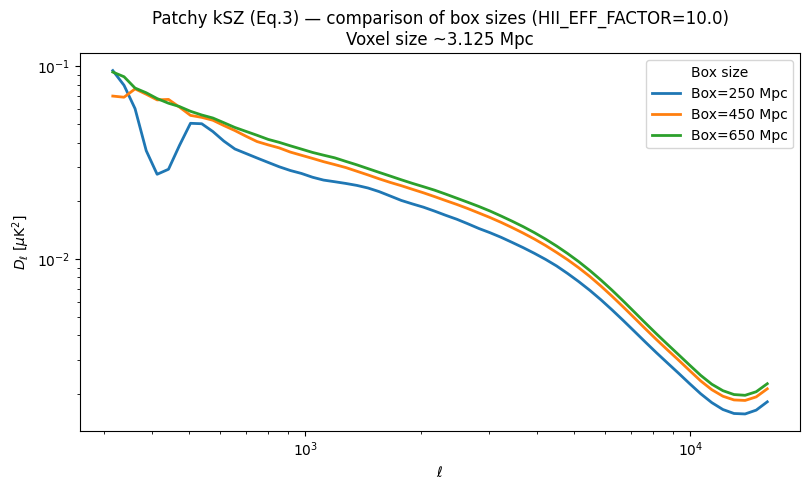

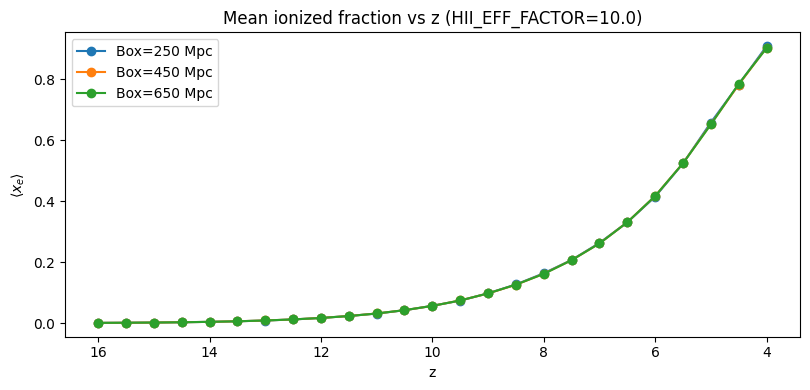

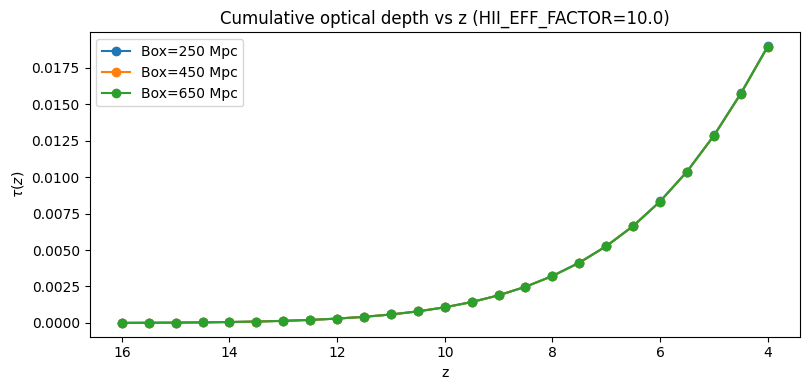

Done. Cached per-(z,box_size) P(k) arrays in /home/swanith/Desktop/Project2/Plots/Box_Size_change_v3.3.1/pq_cache


In [ ]:
# re-use interp_loglog
def interp_loglog(xq, xp, fp):
    xp = np.asarray(xp); fp = np.asarray(fp)
    m  = (xp > 0) & (fp > 0)
    lx = np.log(xp[m]); lf = np.log(fp[m])
    # clip query to xp range to avoid extrapolation issues
    lq = np.log(np.clip(xq, xp[m].min(), xp[m].max()))
    return np.exp(np.interp(lq, lx, lf, left=lf[0], right=lf[-1]))

# compute or load per-(z,box) binned P(k); also cache mean x_e for that z
def compute_or_load_zbox(z, box_size, hii_dim, force=False):
    # cache file names
    fname = cache_dir / f"pk_z{z}_box{int(box_size)}_dim{hii_dim}.npz"
    if fname.exists() and not force:
        dat = np.load(fname)
        return dat["k"], dat["P"], float(dat["xe_mean"])
    # not cached: run coeval, compute P(k)
    delta, chi, vx, vy, vz = run_coeval_fields(z, HII_DIM=hii_dim, BOX_LEN=box_size,
                                               astro_overrides={"HII_EFF_FACTOR": FIXED_HII_EFF_FACTOR})
    # store mean xe for this cube
    xe_mean = float(chi.mean())
    # compute q-perp power
    kbins, Pbins, *_ = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN=box_size, nbins=None)
    np.savez(fname, k=kbins, P=Pbins, xe_mean=xe_mean)
    return kbins, Pbins, xe_mean

# helper: pretty label and filename fragment from box_size
def boxlabel_and_frag(box_size):
    if box_size >= 1000:
        gpc = box_size / 1000.0
        label = f"{gpc:.0f} Gpc" if gpc.is_integer() else f"{gpc:.1f} Gpc"
        frag = label.replace(' ', '').replace('.', 'p')
    else:
        label = f"{box_size:.0f} Mpc"
        frag = f"{int(box_size)}Mpc"
    return label, frag

# geometry arrays (sorted high->low for integration)
ZS_run = np.array(ZS, dtype=float)
zsort_asc = np.argsort(ZS_run)
chis = np.array([cosmo.comoving_distance(z).value for z in ZS_run])  # [Mpc] (increasing with z)
a_z   = 1.0/(1.0 + ZS_run)
# reorder high->low
ZS_sorted = ZS_run[zsort_asc]
chi_sorted = chis[zsort_asc]
a_sorted = a_z[zsort_asc]
# dchi (comoving widths) from geometry
dchi_sorted = np.empty_like(chi_sorted)
dchi_sorted[1:] = np.diff(chi_sorted)
dchi_sorted[0] = dchi_sorted[1] if len(dchi_sorted)>1 else 0.0
dchi_sorted = np.abs(dchi_sorted)
ds_cm_sorted = dchi_sorted * MPC_CM

# ell grid
ells = np.unique(np.round(np.logspace(2.5, 4.2, 60))).astype(int)

# prefactor in Eq.(3)
pref = (sigma_T * ne0 / c_cms)**2

# containers for plotting and summary
Dell_dict = {}      # maps frag -> D_ell array
xe_by_box = {}      # maps frag -> (z_sorted, xe_sorted)
tau_by_box = {}     # maps frag -> (z_sorted, tau_sorted)

# MAIN loop over BOX_SIZES
for box_size in BOX_SIZES:
    hii_dim = int(BASE_HII_DIM * (box_size / BASE_BOX_LEN) + 0.5)  # scale HII_DIM proportionally
    lab, frag = boxlabel_and_frag(box_size)
    voxel = box_size / hii_dim
    BOX_LABEL = f"Box: {box_size:.0f} Mpc, {hii_dim}^3 (Δx={voxel:.2f} Mpc)"
    print(f"\nProcessing {BOX_LABEL} (HII_EFF_FACTOR={FIXED_HII_EFF_FACTOR}) ...")
    # collect per-z P(k) and xe means
    k_list = []
    P_list = []
    xe_means = []
    for z in ZS_sorted:  # compute in high->-low order
        kb, Pb, xe_mean = compute_or_load_zbox(z, box_size, hii_dim, force=False)
        k_list.append(np.asarray(kb))
        P_list.append(np.asarray(Pb))
        xe_means.append(float(xe_mean))

    # store xe sorted by the same high->low z order
    xe_sorted = np.array(xe_means)
    xe_by_box[frag] = (ZS_sorted.copy(), xe_sorted.copy())

    # compute tau(z) integrated high->-low using xe_sorted
    tau = np.zeros_like(ZS_sorted, dtype=float)
    running = 0.0
    for i in range(len(ZS_sorted)-1):
        zmid = 0.5*(ZS_sorted[i] + ZS_sorted[i+1])
        a_mid = 1.0/(1.0 + zmid)
        xe_mid = 0.5*(xe_sorted[i] + xe_sorted[i+1])
        dtaus = sigma_T * ne0 * xe_mid * (a_mid**-2) * (dchi_sorted[i] * MPC_CM)
        running += dtaus
        tau[i+1] = running
    tau_by_box[frag] = (ZS_sorted.copy(), tau.copy())

    # Eq.(3) accumulation: C_ell = pref * Σ_i [ e^{-2τ_i} / (s_i^2 a_i^4) * P(k = ℓ/s_i, z_i) * ds_i ]
    vis2_sorted = np.exp(-2.0 * tau)   # visibility
    C_ell = np.zeros_like(ells, dtype=float)
    for i in range(len(ZS_sorted)):
        s = chi_sorted[i]
        a = a_sorted[i]
        w = vis2_sorted[i] / (s**2 * a**4) * (dchi_sorted[i])
        k_now = ells / s   # ℓ / s [Mpc^-1]
        # interpolate P onto k_now using log-log interpolation (clip within kb range)
        P_now = interp_loglog(k_now, k_list[i], P_list[i])
        C_ell += pref * w * P_now * (MPC_CM**2)

    D_ell_uK2 = ells*(ells+1.0)/(2.0*np.pi) * C_ell * (T_CMB_K**2) * (1e6**2)
    Dell_dict[frag] = (ells.copy(), D_ell_uK2.copy())

    # quick print
    D3000 = float(np.interp(3000.0, ells, D_ell_uK2))
    print(f"  D_3000 (μK^2) ≈ {D3000:.4g}  (cached as {frag})")

# ----------------------------
# Now plotting: overlay D_ells, and show <x_e>(z), tau(z)
# ----------------------------
plt.figure(figsize=(8.2,5.0))
for box_size in BOX_SIZES:
    lab, frag = boxlabel_and_frag(box_size)
    ells_plot, Dell = Dell_dict[frag]
    plt.loglog(ells_plot, Dell, lw=2, label=f"Box={lab}")
plt.xlabel(r"$\ell$"); plt.ylabel(r"$D_\ell$ [$\mu$K$^2$]")
plt.title(f"Patchy kSZ (Eq.3) — comparison of box sizes (HII_EFF_FACTOR={FIXED_HII_EFF_FACTOR})\nVoxel size ~3.125 Mpc")
plt.legend(title="Box size")
plt.tight_layout()
plt.savefig("D_ell_overlay_boxsizes.png", dpi=200)
plt.show()

# plot <x_e>(z) for each box size
plt.figure(figsize=(8.2,4.0))
for box_size in BOX_SIZES:
    _, frag = boxlabel_and_frag(box_size)
    zs_plot, xe_plot = xe_by_box[frag]
    # restore to ascending redshift order for plotting convenience (low->high)
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], xe_plot[order_plot], marker='o', label=f"Box={boxlabel_and_frag(box_size)[0]}")
plt.xlabel("z"); plt.ylabel(r"$\langle x_e \rangle$")
plt.title(f"Mean ionized fraction vs z (HII_EFF_FACTOR={FIXED_HII_EFF_FACTOR})")
plt.gca().invert_xaxis()  # optional: show high z on left
plt.legend(); plt.tight_layout(); plt.savefig("xe_vs_z_allboxes.png", dpi=200); plt.show()

# plot tau(z) for each box size
plt.figure(figsize=(8.2,4.0))
for box_size in BOX_SIZES:
    _, frag = boxlabel_and_frag(box_size)
    zs_plot, tau_plot = tau_by_box[frag]
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], tau_plot[order_plot], marker='o', label=f"Box={boxlabel_and_frag(box_size)[0]}")
plt.xlabel("z"); plt.ylabel(r"$\tau(z)$")
plt.title(f"Cumulative optical depth vs z (HII_EFF_FACTOR={FIXED_HII_EFF_FACTOR})")
plt.gca().invert_xaxis()
plt.legend(); plt.tight_layout(); plt.savefig("tau_vs_z_allboxes.png", dpi=200); plt.show()

print("Done. Cached per-(z,box_size) P(k) arrays in", cache_dir.resolve())